# LangChain

This notebook implements a prompt chain with LangChain framework, fine-tuning DeepSeek to conduct sentiment analysis on our dataset.

## 1. Import Libraries

In [1]:
!pip install -U langchain langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM, T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from langchain.prompts import PromptTemplate
from langchain_community.llms import HuggingFacePipeline
from langchain.chains import LLMChain
import json
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import accelerate
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset

!git clone https://github.com/CKZ1107/COMP6713-NLP.git
%cd COMP6713-NLP
from helpers.setup import *
from helpers.model import *
from helpers.evaluation import *
from helpers.dataset import get_split_datasets

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Cloning into 'COMP6713-NLP'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 3.32 MiB | 2.12 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/Users/carey/Desktop/COMP6713/Group Project/scripts/LangChain/COMP6713-NLP
NLTK resource download complete
MPS (Apple Silicon) device detected!


[nltk_data] Downloading package punkt to /Users/carey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/carey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/carey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/carey/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/carey/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 2. Prepare Dataset

In [ ]:
# Model hyperparameters
max_chunk_length = 256
max_chunks = 8
batch_size = 4
num_epochs = 45
learning_rate = 2e-5
aggregation_method = 'attention'
use_wordnet = True
dataset_path = 'dataset.csv'
label_list = [-1, 1]

# Split datasets
df = pd.read_csv(dataset_path)
train_datasets, val_datasets, test_datasets = get_split_datasets(
    df, labels=label_list, use_wordnet=use_wordnet, max_chunk_length=max_chunk_length, max_chunks=max_chunks
)
_, train_df = train_datasets
_, val_df = val_datasets
_, test_df = test_datasets


Train set: 2979 examples
Validation set: 590 examples
Test set: 615 examples

Testing WordNet enhancement...
Original: I bought my first $AAPL stock in 2010. Since then it has seen a 1,372.29% increase. Tell me again. W...
Enhanced: I bought my first $AAPL stock in 2010 . Since then it has have seen a 1,372.29% increase addition . ...

Original: Why can XPeng P5 deliver outstanding performance in extreme conditions? CEO He Xiaopeng explains the...
Enhanced: Why can tin XPeng P5 deliver outstanding performance in extreme conditions ? CEO He Xiaopeng explain...

Original: @TSM_Myth You dismantled me mentally and emotionally today [SEP] @TSM_Myth You did great! Dont be so...
Enhanced: @TSM_Myth You dismantled level me mentally and emotionally today [SEP] @TSM_Myth You did make great ...



## 3. Fine-tuning using LoRA

In [ ]:
# Convert to input-output format for LoRA
def convert(row):
    return {
        "input": f"Classify sentiment: {row['post']}",
        "output": row["label"]
    }

converted = df.apply(convert, axis=1).tolist()
dataset = Dataset.from_list(converted)

# Split the dataset
split_dataset = dataset.train_test_split(test_size=0.3)
train_data = split_dataset["train"]
eval_data = split_dataset["test"]

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")

def tokenize(example):
    model_inputs = tokenizer(
        example["input"], truncation=True, padding="max_length", max_length=512
    )
    labels = tokenizer(
        example["output"], truncation=True, padding="max_length", max_length=8
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_data.map(tokenize)
tokenized_eval = eval_data.map(tokenize)

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl", torch_dtype=torch.bfloat16)

# Apply LoRA
target_modules = ["q", "v"]
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=target_modules
)
model = get_peft_model(model, peft_config)

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./flan_lora_sentiment",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    learning_rate=1e-4,
    num_train_epochs=3,
    save_strategy="epoch",
    report_to="none",
    fp16=True,
    push_to_hub=False
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model)
)

# Train the model
trainer.train()

# Save the adapter model
model.save_pretrained("flan-lora-adapter")
tokenizer.save_pretrained("flan-lora-adapter")

In [6]:
!rm -rf ~/.cache/huggingface

## 3. Model setup

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("flan-lora-adapter")
tokenizer = T5Tokenizer.from_pretrained("flan-lora-adapter")

# Create pipeline
pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=10,
    device=0 if torch.cuda.is_available() else -1
)

llm = HuggingFacePipeline(pipeline=pipe)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

KeyboardInterrupt: 

## 4. Propmt Template with 3D Inputs (time, stock, post)

In [ ]:
def build_few_shot_prompt(post_to_classify, df, num_examples=3):
    labeled_df = df[["post", "label"]].dropna()
    examples = labeled_df.sample(n=num_examples, random_state=42)
    
    prompt = ""
    for i, row in enumerate(examples.itertuples(), 1):
        label_text = "Increase" if row.label == 1 else "Decrease"
        prompt += f"Example {i}:\nPost: {row.post}\nLabel: {label_text}\n\n"

    prompt += f"Now, classify the sentiment of the following post:\nPost: {post_to_classify}\nLabel:"
    return prompt

template = """
You are a financial expert who's been doing sentiment analysis on social media for years.

{few_shot}

Given the following social media post with timestamp and stock code:

Time: {time}
Stock: {stock}
Post: "{post}"

Classify the sentiment of this post toward the stock price.
Respond in JSON format with three fields:
- sentiment: one of [positive, negative]
- justification: your reasoning, 1-2 sentences long

Your answer:
"""

prompt = PromptTemplate(
    input_variables=["few_shot", "time", "stock", "post"],
    template=template,
)

chain = LLMChain(llm=llm, prompt=prompt)

In [ ]:
def classify_with_voting(row, n_votes=5):
    predictions = []
    prompt_text = build_few_shot_prompt(post_to_classify=row["post"][:450], full_df=train_df)
    
    for i in range(n_votes):
        try:
            response = chain.invoke({
                "few_shot": prompt_text,
                "time": str(row["trading_day"]),
                "stock": row["stock"],
                "post": row["post"][:450]
            })

            if "text" in response:
                predictions.append(response["text"].lower())
            else:
                print(f"❌ Run {i+1}: Missing 'prediction' key →", response)

        except Exception as e:
            print(f"❌ Run {i+1} failed for row:\n{row}")
            print("❌ Error:", e)

    if predictions:
        # Count and return the majority prediction
        prediction_counts = Counter(predictions)
        majority = prediction_counts.most_common(1)[0][0]
        return majority
    else:
        return "unknown"

In [11]:
test_df["majority_sentiment"] = test_df.apply(classify_with_voting, axis=1)

def map_prediction_to_label(prediction_str):
    pred = prediction_str.strip().lower()
    if "positive" in pred:
        return 1
    elif "negative" in pred:
        return -1
    else:
        return None

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Accuracy: 0.5138
F1 Score: 0.4839


<Figure size 600x600 with 0 Axes>

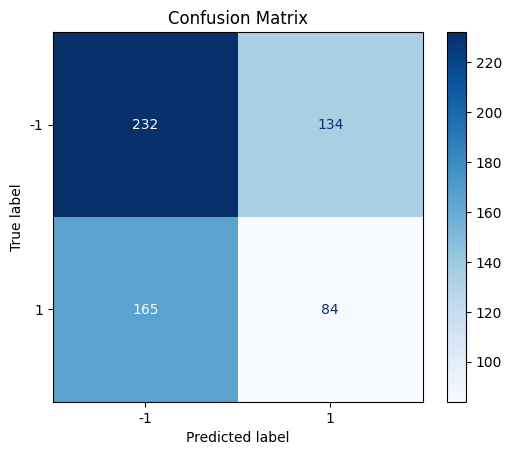

In [12]:
y_true = test_df["label"]
y_pred = test_df["majority_sentiment"].apply(map_prediction_to_label)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

labels = [-1, 1]

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()